# **Welcome To the Notebook** 


### **Task 1 - Loading our data**

Installing the pyspark using pip

In [1]:
!pip install pyspark


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


Importing Modules

In [2]:
# importing spark session
from pyspark.sql import SparkSession

# data visualization modules 
import matplotlib.pyplot as plt
import plotly.express as px 

# pandas module 
import pandas as pd

# pyspark SQL functions 
from pyspark.sql.functions import col, when, count, udf

# pyspark data preprocessing modules
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder

# pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator


Building our Spark Session

In [3]:
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/24 11:12:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Loading our data

In [5]:
data = spark.read.format('csv').option("inferSchema",True).option("header",True).load("Datasets/dataset.csv")
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

Print the data schema to check out the data types

In [6]:
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



Get the data dimension 

In [7]:
len(data.columns)

21

In [8]:
data.count()

7043

### **Task 2 - Exploratory Data Analysis**
- Distribution Analysis
- Correlation Analysis 
- Univariate Analysis 
- Finding Missing values

Let's define some lists to store different column names with different data types.

In [9]:
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [10]:
data.dtypes

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'string'),
 ('Partner', 'string'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('InternetService', 'string'),
 ('OnlineSecurity', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingTV', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('MonthlyCharges', 'double'),
 ('TotalCharges', 'double'),
 ('Churn', 'string')]

In [11]:
numerical_columns = [name for name, typ in data.dtypes if typ =="double" or typ =="int"]
categorical_columns = [name for name, typ in data.dtypes if typ =="string"]

data.select(categorical_columns).show()

+----------+------+-------------+-------+----------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|Churn|
+----------+------+-------------+-------+----------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|          No|No phone service|            DSL|                 No|                Yes|                 No|        

Let's get all the numerical features and store them into a pandas dataframe.

In [12]:
df = data.select(numerical_columns).toPandas()
df.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


Let's create histograms to analyse the distribution of our numerical columns. 

count    7043.000000
mean       32.435752
std        25.075228
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max       458.000000
Name: tenure, dtype: float64

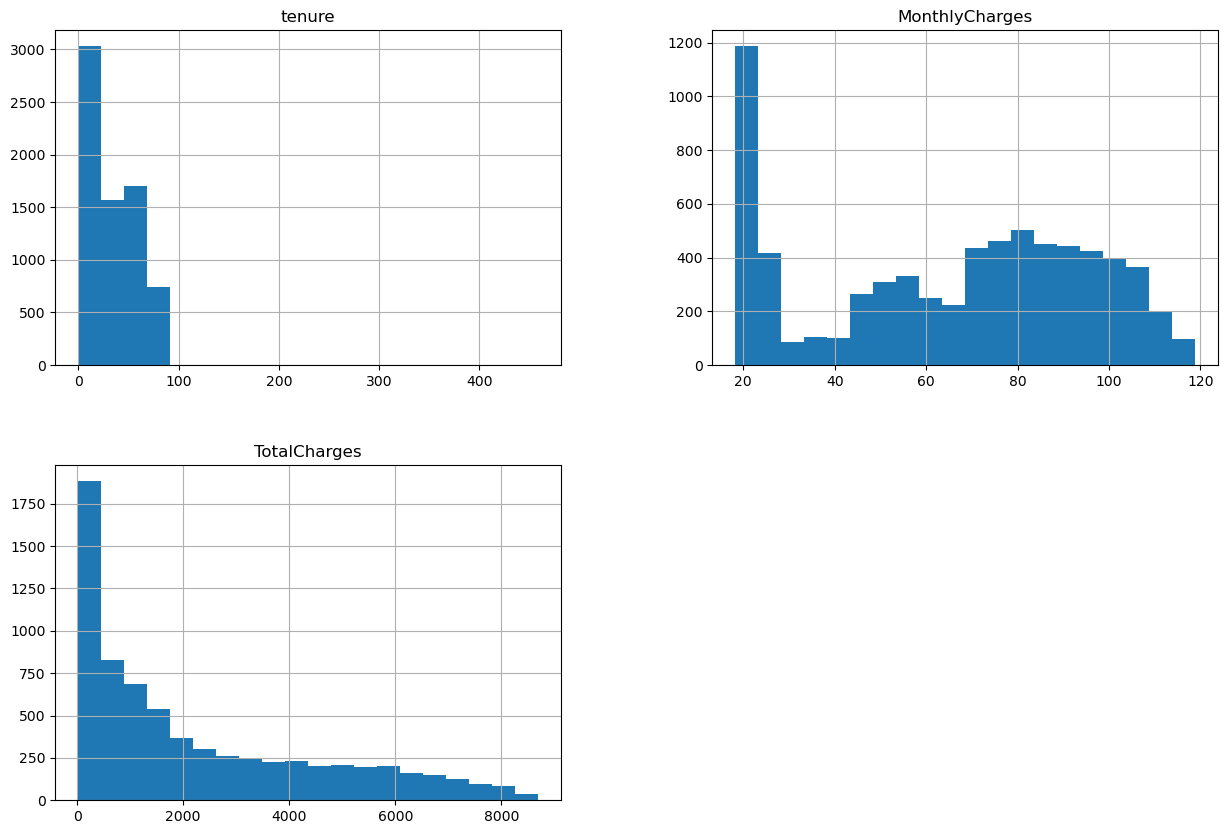

In [13]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca()
df.hist(ax=ax, bins = 20)
df.tenure.describe()

Let's generate the correlation matrix 

In [14]:
df.corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.243703,0.806530
MonthlyCharges,0.243703,1.000000,0.651065
TotalCharges,0.806530,0.651065,1.000000


Let's check the unique value count per each categorical variables

In [15]:
for colm in categorical_columns:
    data.groupby(colm).count().show()

+----------+-----+
|customerID|count|
+----------+-----+
|3668-QPYBK|    1|
|6234-RAAPL|    1|
|1894-IGFSG|    1|
|6982-SSHFK|    1|
|5859-HZYLF|    1|
|6479-OAUSD|    1|
|2592-YKDIF|    1|
|6718-BDGHG|    1|
|3195-TQDZX|    1|
|4248-QPAVC|    1|
|5668-MEISB|    1|
|5802-ADBRC|    1|
|2712-SYWAY|    1|
|2011-TRQYE|    1|
|7244-KXYZN|    1|
|0953-LGOVU|    1|
|3623-FQBOX|    1|
|3692-JHONH|    1|
|3528-HFRIQ|    1|
|7661-CPURM|    1|
+----------+-----+
only showing top 20 rows

+------+-----+
|gender|count|
+------+-----+
|Female| 3488|
|  Male| 3555|
+------+-----+

+-------------+-----+
|SeniorCitizen|count|
+-------------+-----+
|           No| 5901|
|          Yes| 1142|
+-------------+-----+

+-------+-----+
|Partner|count|
+-------+-----+
|     No| 3641|
|    Yes| 3402|
+-------+-----+

+----------+-----+
|Dependents|count|
+----------+-----+
|        No| 4933|
|       Yes| 2110|
+----------+-----+

+------------+-----+
|PhoneService|count|
+------------+-----+
|          No|  682

Let's find number of null values in all of our dataframe columns

In [16]:
for column in data.columns:
    data.select(count(when(col(column).isNull(), "Churn")).alias(column)).show()

+----------+
|customerID|
+----------+
|         0|
+----------+

+------+
|gender|
+------+
|     0|
+------+

+-------------+
|SeniorCitizen|
+-------------+
|            0|
+-------------+

+-------+
|Partner|
+-------+
|      0|
+-------+

+----------+
|Dependents|
+----------+
|         0|
+----------+

+------+
|tenure|
+------+
|     0|
+------+

+------------+
|PhoneService|
+------------+
|           0|
+------------+

+-------------+
|MultipleLines|
+-------------+
|            0|
+-------------+

+---------------+
|InternetService|
+---------------+
|              0|
+---------------+

+--------------+
|OnlineSecurity|
+--------------+
|             0|
+--------------+

+------------+
|OnlineBackup|
+------------+
|           0|
+------------+

+----------------+
|DeviceProtection|
+----------------+
|               0|
+----------------+

+-----------+
|TechSupport|
+-----------+
|          0|
+-----------+

+-----------+
|StreamingTV|
+-----------+
|          0|
+----------

### **Task 3 - Data Preprocessing**
- Handling the missing values
- Removing the outliers

**Handling the missing values** <br>
Let's create a list of column names with missing values

In [17]:
columns_with_missing_value = ["TotalCharges"]

Creating our Imputer

In [18]:
imputer = Imputer(inputCols = columns_with_missing_value, outputCols = columns_with_missing_value).setStrategy("mean")

Use Imputer to fill the missing values

In [19]:
imputer = imputer.fit(data)
data = imputer.transform(data)

Let's check the missing value counts again

In [20]:
data.select(count(when(col(column).isNull(), "TotalCharges")).alias("TotalCharges")).show()

+------------+
|TotalCharges|
+------------+
|           0|
+------------+



**Removing the outliers** <br>
Let's find the customer with the tenure higher than 100 

In [21]:
data.select("*").where(data.tenure>100).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|5122-CYFXA|Female|           No|     No|        No|   458|         Yes|           No|            DSL|            No|         Yes|              No|        Yes|        Yes|            Yes|

Let's drop the outlier row

In [22]:
print("Before removing the outlier", data.count())
data = data.filter(data.tenure < 100)
print("After removing the outlier", data.count())

Before removing the outlier 7043
After removing the outlier 7042


### **Task 4 - Feature Preparation**
- Numerical Features 
    - Vector Assembling
    - Numerical Scaling
- Categorical Features
    - String Indexing
    - Vector Assembling

- Combining the numerical and categorical feature vectors




**Feature Preparation - Numerical Features** <br>

`Vector Assembling --> Standard Scaling` <br>

**Vector Assembling** <br>
To apply our machine learning model we need to combine all of our numerical and categorical features into vectors. For now let's create a feature vector for our numerical columns.


In [23]:
numerical_vector_assembler = VectorAssembler(inputCols = numerical_columns, outputCol = "numerical_features_vector")
data = numerical_vector_assembler.transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+----------

**Numerical Scaling** <br>
Let's standardize all of our numerical features. 

In [24]:
scaler = StandardScaler(inputCol = "numerical_features_vector",
                       outputCol = "numerical_features_scaled", withStd = True, withMean = True)
data = scaler.fit(data).transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+-------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vector|numerical_features_scaled|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-------------

**Feature Preperation - Categorical Features** <br>

`String Indexing --> Vector Assembling` <br>

**String Indexing** <br>
We need to convert all the string columns to numeric columns.

In [25]:
categorical_columns_indexed = [name + "_Indexed" for name in categorical_columns]

indexer = StringIndexer(inputCols = categorical_columns, outputCols = categorical_columns_indexed)

data = indexer.fit(data).transform(data)
data.show()

24/09/24 11:26:24 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       Pa

Let's combine all of our categorifal features in to one feature vector.

In [28]:
categorical_columns_indexed

['customerID_Indexed',
 'gender_Indexed',
 'SeniorCitizen_Indexed',
 'Partner_Indexed',
 'Dependents_Indexed',
 'PhoneService_Indexed',
 'MultipleLines_Indexed',
 'InternetService_Indexed',
 'OnlineSecurity_Indexed',
 'OnlineBackup_Indexed',
 'DeviceProtection_Indexed',
 'TechSupport_Indexed',
 'StreamingTV_Indexed',
 'StreamingMovies_Indexed',
 'Contract_Indexed',
 'PaperlessBilling_Indexed',
 'PaymentMethod_Indexed',
 'Churn_Indexed']

In [29]:
categorical_columns_indexed.remove("customerID_Indexed")
categorical_columns_indexed.remove("Churn_Indexed")

In [32]:
categorical_vector_assembler = VectorAssembler(inputCols = categorical_columns_indexed, outputCol = "categorical_features_vector")
data = categorical_vector_assembler.transform(data)

data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+-------------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+---------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contrac

Now let's combine categorical and numerical feature vectors.

In [33]:
final_vector_assembler = VectorAssembler(inputCols = ["categorical_features_vector","numerical_features_scaled"], outputCol = "final_feature_vector")
data = final_vector_assembler.transform(data)

data.select(["final_feature_vector","Churn_Indexed"]).show()

+--------------------+-------------+
|final_feature_vector|Churn_Indexed|
+--------------------+-------------+
|(19,[0,2,4,5,6,8,...|          0.0|
|(19,[6,7,9,13,14,...|          0.0|
|(19,[6,7,8,15,16,...|          1.0|
|[0.0,0.0,0.0,0.0,...|          0.0|
|(19,[0,16,17,18],...|          1.0|
|(19,[0,5,9,11,12,...|          1.0|
|(19,[3,5,8,11,15,...|          0.0|
|(19,[0,4,5,6,7,14...|          0.0|
|(19,[0,2,5,9,10,1...|          1.0|
|(19,[3,6,7,8,13,1...|          0.0|
|(19,[2,3,6,7,15,1...|          0.0|
|[0.0,0.0,0.0,0.0,...|          0.0|
|(19,[2,5,9,11,12,...|          0.0|
|(19,[5,8,9,11,12,...|          1.0|
|(19,[7,9,10,11,12...|          0.0|
|[1.0,0.0,1.0,1.0,...|          0.0|
|[1.0,0.0,0.0,0.0,...|          0.0|
|[0.0,0.0,0.0,1.0,...|          0.0|
|(19,[0,2,3,6,9,10...|          1.0|
|(19,[0,8,9,12,16,...|          0.0|
+--------------------+-------------+
only showing top 20 rows



### **Task 5 - Model Training**
- Train and Test data splitting 
- Creating our model 
- Training our model 
- Make initial predictions using our model

In this task, we are going to start training our model

In [35]:
train, test = data.randomSplit([0.7,0.3], seed = 100)
test.count()

2112

Now let's create and train our desicion tree

In [47]:
dt = DecisionTreeClassifier(featuresCol = "final_feature_vector", labelCol = "Churn_Indexed", maxDepth = 6)
model = dt.fit(train)

Let's make predictions on our test data

In [48]:
predictions_test = model.transform(test)
predictions_test.select(["Churn","prediction"]).show()

+-----+----------+
|Churn|prediction|
+-----+----------+
|  Yes|       1.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       1.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|   No|       1.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
+-----+----------+
only showing top 20 rows



### **Task 6 - Model Evaluation**
- Calculating area under the ROC curve for the `test` set 
- Calculating area under the ROC curve for the `training` set 
- Hyper parameter tuning

In [49]:
evaluator = BinaryClassificationEvaluator(labelCol = "Churn_Indexed")
auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
auc_test

0.7968240892739675

Let's get the AUC for our `training` set

In [50]:
predictions_train = model.transform(train)
auc_train = evaluator.evaluate(predictions_train, {evaluator.metricName: "areaUnderROC"})
auc_train

0.797607974377661

**Hyper parameter tuning**

Let's find the best `maxDepth` parameter for our DT model. 

In [51]:
def evaluate_dt(mode_params):
      test_accuracies = []
      train_accuracies = []

      for maxD in mode_params:
        # train the model based on the maxD
        decision_tree = DecisionTreeClassifier(featuresCol = 'final_feature_vector', labelCol = 'Churn_Indexed', maxDepth = maxD)
        dtModel = decision_tree.fit(train)

        # calculating test error 
        predictions_test = dtModel.transform(test)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_Indexed")
        auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})
        # recording the accuracy 
        test_accuracies.append(auc_test)

        # calculating training error
        predictions_training = dtModel.transform(train)
        evaluator = BinaryClassificationEvaluator(labelCol="Churn_Indexed")
        auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
        train_accuracies.append(auc_training)

      return(test_accuracies, train_accuracies)  

Let's define `params` list to evaluate our model iteratively with differe maxDepth parameter.  

In [52]:
maxDepths = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
test_accs, train_accs = evaluate_dt(maxDepths)
print(train_accs)
print(test_accs)

[0.7737711024910238, 0.7721112330375414, 0.6732017750857608, 0.5647403286677019, 0.797607974377661, 0.7600331160893413, 0.7616399322585649, 0.7851198149534798, 0.82591977092655, 0.8633625692715379, 0.8899907318309699, 0.9236516335825413, 0.9402616892332477, 0.9521037242780167, 0.9662424766482165, 0.9763120733848871, 0.9807472862567603, 0.9853808496196841, 0.9883361989750398]
[0.7918744332963926, 0.7678230877272001, 0.6938514510575503, 0.5664944085244075, 0.7968240892739675, 0.7464077658395512, 0.7486976928866473, 0.7390283218461648, 0.7568262227463716, 0.7717528253693575, 0.770466222983424, 0.7493673661690539, 0.7371905724224987, 0.7208594338001293, 0.7102797812005524, 0.704298946894316, 0.7036452746549405, 0.6956814962753128, 0.6895714683623821]


Let's visualize our results

In [53]:
df = pd.DataFrame()
df["maxDepth"] = maxDepths
df["trainAcc"] = train_accs
df["testAcc"] = test_accs

px.line(df, x="maxDepth", y=["trainAcc","testAcc"])

### **7 - Model Deployment**
- Giving Recommendations using our model 



We were asked to recommend a solution to reduce the customer churn. 


In [55]:
feature_importance = model.featureImportances
scores = [score for i, score in enumerate(feature_importance)]
df = pd.DataFrame(scores, columns = ["score"], index = categorical_columns_indexed + numerical_columns)

px.bar(df, y="score")

Let's create a bar chart to visualize the customer churn per contract type

In [57]:
df = data.groupby(["Contract","Churn"]).count().toPandas()
px.bar(df, x="Contract", y="count", color = "Churn")

The bar chart displays the number of churned customers based on their contract type. It is evident that customers with a "Month-to-month" contract have a higher churn rate compared to those with "One year" or "Two year" contracts. As a recommendation, the telecommunication company could consider offering incentives or discounts to encourage customers with month-to-month contracts to switch to longer-term contracts. 